In [ ]:
# pip install cgal
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_3
from CGAL.CGAL_Kernel import Plane_3
from CGAL import CGAL_Convex_hull_3
from CGAL.CGAL_Polyhedron_3 import Polyhedron_3

pts = []
pts.append(Point_3(0, 0, 0))
pts.append(Point_3(0, 1, 0))
pts.append(Point_3(1, 1, 0))
pts.append(Point_3(1, 0, 0))
pts.append(Point_3(0, 0, 1))
pts.append(Point_3(0, 1, 1))
pts.append(Point_3(1, 1, 1))
pts.append(Point_3(1, 0, 1))

res = Polyhedron_3()

CGAL_Convex_hull_3.convex_hull_3(pts, res)

print("convex hull has ", res.size_of_vertices(), " vertices")
print("is strongly convex: ", CGAL_Convex_hull_3.is_strongly_convex_3(res))

planes = []
planes.append(Plane_3(-1, 0, 0, 0))
planes.append(Plane_3(1, 0, 0, -1))
planes.append(Plane_3(0, -1, 0, 0))
planes.append(Plane_3(0, 1, 0, -1))
planes.append(Plane_3(0, 0, -1, 0))
planes.append(Plane_3(0, 0, 1, -1))

res.clear()
CGAL_Convex_hull_3.halfspace_intersection_3(planes, res)
print("halfspace intersection has ", res.size_of_vertices(), " vertices")

In [ ]:
# This code is a python re-implementation of an example entitled
# "Triangulating a Polygonal Domain" from the CGAL documentation,
# in the Chapter entitled "2D Triangulation"
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Constrained_Delaunay_triangulation_2


class FaceInfo2(object):
    def __init__(self):
        self.nesting_level = -1

    def in_domain(self):
        return (self.nesting_level % 2) != 1


def mark_domains(ct, start_face, index, edge_border, face_info):
    if face_info[start_face].nesting_level != -1:
        return
    queue = [start_face]
    while queue != []:
        fh = queue[0]  # queue.front
        queue = queue[1:]  # queue.pop_front
        if face_info[fh].nesting_level == -1:
            face_info[fh].nesting_level = index
            for i in range(3):
                e = (fh, i)
                n = fh.neighbor(i)
                if face_info[n].nesting_level == -1:
                    if ct.is_constrained(e):
                        edge_border.append(e)
                    else:
                        queue.append(n)


def mark_domain(cdt):
    """Find a mapping that can be tested to see if a face is in a domain
    Explore the set of facets connected with non constrained edges,
    and attribute to each such set a nesting level.
    We start from the facets incident to the infinite vertex, with a
    nesting level of 0. Then we recursively consider the non-explored
    facets incident to constrained edges bounding the former set and
    increase the nesting level by 1.
    Facets in the domain are those with an odd nesting level.
    """
    face_info = {}
    for face in cdt.all_faces():
        face_info[face] = FaceInfo2()
    index = 0
    border = []
    mark_domains(cdt, cdt.infinite_face(), index + 1, border, face_info)
    while border != []:
        e = border[0]  # border.front
        border = border[1:]  # border.pop_front
        n = e[0].neighbor(e[1])
        if face_info[n].nesting_level == -1:
            lvl = face_info[e[0]].nesting_level + 1
            mark_domains(cdt, n, lvl, border, face_info)
    return face_info


def insert_polygon(cdt, polygon):
    if not polygon:
        return

    handles = [cdt.insert(polypt) for polypt in polygon]
    for i in range(len(polygon) - 1):
        cdt.insert_constraint(handles[i], handles[i + 1])
    cdt.insert_constraint(handles[-1], handles[0])


if __name__ == "__main__":

    def plot_triangulated_polygon(cdt, face_info):
        # This code is an additional element which recreates the figure
        # presented in the original CGAL example. Given the ease of which
        # a standard plotting library can be installed for python, it
        # makes sense to offer some form of visualisation directly
        try:
            import matplotlib.pyplot as plt
        except Exception:
            print('plotting of triangulation not supported')
            return

        def rescale_plot(ax, scale=1.1):
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xmid = (xmin + xmax) / 2.0
            ymid = (ymin + ymax) / 2.0
            xran = xmax - xmid
            yran = ymax - ymid
            ax.set_xlim(xmid - xran * scale, xmid + xran * scale)
            ax.set_ylim(ymid - yran * scale, ymid + yran * scale)

        def plot_edge(edge, *args):
            edge_seg = cdt.segment(edge)
            pts = [edge_seg.source(), edge_seg.target()]
            xs = [pts[0].x(), pts[1].x()]
            ys = [pts[0].y(), pts[1].y()]
            plt.plot(xs, ys, *args)

        for edge in cdt.finite_edges():
            if cdt.is_constrained(edge):
                plot_edge(edge, 'r-')
            else:
                if face_info[edge[0]].in_domain():
                    plot_edge(edge, 'b-')
        rescale_plot(plt.gca())
        plt.show()

    def main():
        # Construct two non-intersecting nested polygons
        polygon1 = [Point_2(0, 0), Point_2(2, 0), Point_2(2, 2), Point_2(0, 2)]

        polygon2 = [
            Point_2(0.5, 0.5),
            Point_2(1.5, 0.5),
            Point_2(1.5, 1.5),
            Point_2(0.5, 1.5)
        ]

        # Insert the polygons into a constrained triangulation
        cdt = Constrained_Delaunay_triangulation_2()
        insert_polygon(cdt, polygon1)
        insert_polygon(cdt, polygon2)

        # Mark facest that are inside the domain bounded by the polygon
        face_info = mark_domain(cdt)

        plot_triangulated_polygon(cdt, face_info)

    main()

In [62]:
# Jupyter Notebook Cell Debugging: pip install -U ipykernel
# Create a polygon
# Create a line
# Find intersection point of a line with polygon
# Find sweep optimal direction
# Sweep point based on the line offset
from CGAL.CGAL_Kernel import Polygon_2, Line_2, Segment_2, Point_2, Direction_2, Vector_2, Ray_2, Weighted_point_2
from CGAL.CGAL_Kernel import do_intersect, intersection, squared_distance, orientation, determinant, area, bisector, bounded_side_2,cross_product, left_turn
from CGAL.CGAL_Kernel import COLLINEAR, POSITIVE, NEGATIVE, ORIGIN, CLOCKWISE, COUNTERCLOCKWISE, LEFT_TURN, ON_BOUNDARY, ON_BOUNDED_SIDE, ON_POSITIVE_SIDE, ON_UNBOUNDED_SIDE, ON_NEGATIVE_SIDE
import numpy as np
import pyvisgraph as vg
import matplotlib.pyplot as plt
import pyvisgraph as vg
from matplotlib import cm


def plot_vis_graph(g: vg.VisGraph, ax):
    for edge in g.graph.edges:
        ax.plot([edge.p1.x, edge.p2.x], [edge.p1.y, edge.p2.y],
                c=cm.hot(edge.p1.polygon_id/255), ls="solid", marker="o")


def plot_vis_graph_visibile(g: vg.VisGraph, start: vg.Point, ax):
    for pt in g.find_visible(start):
        ax.plot([start.x, pt.x], [start.y, pt.y], c=cm.hot(
            pt.polygon_id/255), ls="dotted", marker="x")


def plot_vis_graph_path(path: list, ax, params="-ro"):
    x, y = [], []
    for pt in path:
        x.append(pt.x)
        y.append(pt.y)
    ax.plot(x, y, params)


def plot_cgal_polygon2(pg, ax, params="-ro"):
    ec = pg.edges_circulator()
    done = ec.next()  # Termination criteria
    while True:  # Circular iterator loop
        e = ec.next()  # Get next iterator element
        # Process
        ax.plot([e.source().x(), e.target().x()], [
                e.source().y(), e.target().y()], params)
        if e == done:  # Check termination criteria
            break  # Exit loop


def plot_cgal_segment2(ls, ax, params="-ro"):
    ax.plot([ls.source().x(), ls.target().x()], [
            ls.source().y(), ls.target().y()], params)


def plot_cgal_line2(ln, ax, params="-ro"):
    ls = Segment_2(ln.point(-1), ln.point(1))
    plot_cgal_segment2(ls, ax=ax, params=params)


def plot_cgal_waypoints(pts, ax, params="-ro"):
    x, y = [], []
    for pt in pts:
        x.append(pt.x())
        y.append(pt.y())
    ax.plot(x, y, params)


def apply_affine_translation_pt(pt: Point_2, ov: Vector_2):
    # Apply 2D affine translation (given by the vector) to the point
    T = np.array(((1, 0, ov.x()), (0, 1, ov.y()), (0, 0, 1)))
    tpt = T.dot(np.array((pt.x(), pt.y(), 1)))
    return Point_2(tpt[0], tpt[1])

def apply_affine_translation(ls: Segment_2, ov: Vector_2):
    # Apply 2D affine translation (given by the vector) to the line segment
    T = np.array(((1, 0, ov.x()), (0, 1, ov.y()), (0, 0, 1)))
    s = T.dot(np.array((ls.source().x(), ls.source().y(), 1)))
    e = T.dot(np.array((ls.target().x(), ls.target().y(), 1)))
    return Segment_2(Point_2(s[0], s[1]), Point_2(e[0], e[1]))


def project_point_on_polygon_hull(pt: Point_2, pg: Polygon_2, offset=0.001):
    # Reverse polygon orientation if required
    if pg.is_clockwise_oriented():
        pg.reverse_orientation()

    closest_edge = None
    edge_distance = float('inf')

    for edge in pg.edges():
        dist = squared_distance(edge, pt)
        if dist < edge_distance:
            edge_distance = dist
            closest_edge = edge

    # Project on the line going through the edge
    closest_pt_on_edge = closest_edge.supporting_line().projection(pt)
   
    # Check the edge limits
    if closest_pt_on_edge > closest_edge.max():
        closest_pt_on_edge = closest_edge.max()
    elif closest_pt_on_edge < closest_edge.min():
        closest_pt_on_edge = closest_edge.min()

    # Project point at an offset(inward) from the polygon hull.
    dir_vector = closest_edge.supporting_line().perpendicular(closest_pt_on_edge).to_vector()
    dir_vector.normalize()
    offset_vector = offset * dir_vector
    proj_pt = apply_affine_translation_pt(closest_pt_on_edge, offset_vector)
    if pg.bounded_side(proj_pt) != ON_BOUNDED_SIDE:
        offset_vector = -offset * dir_vector # Reverse the direction
        proj_pt = apply_affine_translation_pt(closest_pt_on_edge, offset_vector)

    # Find distance and direction, negative for outward, positive for inward, zero for on-boundary
    edge_distance = np.sqrt(squared_distance(pt, proj_pt)) * closest_edge.supporting_line().oriented_side(proj_pt)
    
    return closest_edge, proj_pt, edge_distance, pg.bounded_side(proj_pt) 


def project_on_polygon_hull(p: vg.Point, g: vg.VisGraph, polygon_id, length):
    """Assumes p is interior to the polygon with polygon_id. Returns the
    closest point c inside the polygon to p, where the distance from c to 
    the intersect point from p to the edge of the polygon is length."""
    polygon_edges = g.graph.polygons[polygon_id]
    close_point = None
    close_edge = None
    close_dist = None
    # Finds point closest to p, but on a edge of the polygon.
    # Solution from http://stackoverflow.com/a/6177788/4896361
    for i, e in enumerate(polygon_edges):
        num = ((p.x-e.p1.x)*(e.p2.x-e.p1.x) + (p.y-e.p1.y)*(e.p2.y-e.p1.y))
        denom = ((e.p2.x - e.p1.x)**2 + (e.p2.y - e.p1.y)**2)
        u = num/denom
        pu = vg.Point(e.p1.x + u*(e.p2.x - e.p1.x),
                      e.p1.y + u*(e.p2.y - e.p1.y))
        pc = pu
        if u < 0:
            pc = e.p1
        elif u > 1:
            pc = e.p2
        d = vg.visible_vertices.edge_distance(p, pc)
        if i == 0 or d < close_dist:
            close_dist = d
            close_point = pc
            close_edge = e

    # Extend the newly found point so it is outside the polygon by `length`.
    if close_point in close_edge:
        c = close_edge.p1 if close_point == close_edge.p1 else close_edge.p2
        edges = list(g.graph[c])
        v1 = vg.visible_vertices.unit_vector(c, edges[0].get_adjacent(c))
        v2 = vg.visible_vertices.unit_vector(c, edges[1].get_adjacent(c))
        vsum = vg.visible_vertices.unit_vector(
            vg.Point(0, 0), vg.Point(v1.x + v2.x, v1.y + v2.y))
        close1 = vg.Point(c.x + (vsum.x * length), c.y + (vsum.y * length))
        close2 = vg.Point(c.x - (vsum.x * length), c.y - (vsum.y * length))
        if vg.visible_vertices.point_in_polygon(close1, g.graph) == -1:
            return close1
        return close2
    else:
        v = vg.visible_vertices.unit_vector(p, close_point)
        if v.x == 0 and v.y == 0:
            # print("calculate normal vector: (-dy, dx) or (dy, -dx)")
            v.x = (close_edge.p1.y - close_edge.p2.y)
            v.y = -(close_edge.p1.x - close_edge.p2.x)

        r = vg.Point(close_point.x + v.x*length, close_point.y + v.y*length)
        if g.point_in_polygon(r) != polygon_id:
            r = vg.Point(close_point.x - v.x*length,
                         close_point.y - v.y*length)

        return r


def build_visgraph(polys: list):
    g = vg.VisGraph()
    # g.build(polys, workers=8, status=True)
    # Manual build, assuming each polygon vertices are in-order (ccw or cw).
    g.graph = vg.Graph(polys)
    g.visgraph = vg.Graph([])

    for edge in g.graph.edges:
        g.visgraph.add_edge(edge)

    return g


def cgal_polygon_properties(pg: Polygon_2):
    print("IsSimple [No intersection and holes]: ", pg.is_simple())
    print("IsConvex [All internal angle < 180]: ", pg.is_convex())
    print("IsClockwiseOriented: ", pg.is_clockwise_oriented())
    print("IsCounterClockwiseOriented: ", pg.is_counterclockwise_oriented())
    print("IsCollinearOriented: ", pg.is_collinear_oriented())
    print("Area: ", pg.area())
    print("Orientation: ", pg.orientation())
    print("Vertices: ", pg.size())
    print("BBox: ", pg.bbox())
    print("BottomVertex: ", pg.bottom_vertex())
    print("RightVertex: ", pg.right_vertex())
    print("TopVertex: ", pg.top_vertex())
    print("LeftVertex: ", pg.left_vertex())


def cgal_line_properties(ln: Line_2):
    print(f"a: {ln.a()}, b: {ln.b()}, c: {ln.c()}")
    print("Direction: ", ln.direction())
    print("IsHorizontal: ", ln.is_horizontal())
    print("IsVertical: ", ln.is_vertical())
    print("IsDegenerate: ", ln.is_degenerate())
    # print("Prependicular: ", ln.perpendicular())


def cgal_linesegment_properties(ls: Segment_2):
    print("Direction: ", ls.direction())
    print("IsHorizontal: ", ls.is_horizontal())
    print("IsVertical: ", ls.is_vertical())
    print("IsDegenerate: ", ls.is_degenerate())
    print("BBox: ", ls.bbox())
    print("Source: ", ls.source())
    print("Target: ", ls.target())
    print("SqLength: ", ls.squared_length())
    print("SupportingLine: ", ls.supporting_line())
    print("DirectionVector: ", ls.to_vector())


pg1 = Polygon_2([Point_2(0, 0), Point_2(1, 0), Point_2(
    2, 1), Point_2(1, 2), Point_2(0, 2)])
pg2 = Polygon_2([Point_2(3, 3), Point_2(7, 3), Point_2(7, 7), Point_2(3, 7)])
pg3 = Polygon_2([Point_2(2, 0), Point_2(10, 0), Point_2(
    10, 10), Point_2(0, 10), Point_2(0, 2), Point_2(2, 2)])
pg4 = Polygon_2([Point_2(2, 0), Point_2(8, 0), Point_2(10, 2), Point_2(
    10, 10), Point_2(0, 10), Point_2(0, 2), Point_2(2, 2)])
pg5 = Polygon_2([Point_2(0, 0), Point_2(110, 0), Point_2(110, 20), Point_2(
    60, 20), Point_2(60, 60), Point_2(0, 60)])  # piombino

start = Point_2(60.00, 30)
goal = Point_2(110.00, 10.00)

# Eq of line passing through points
l1 = Line_2(Point_2(0.4, 0.45), Point_2(0.55, 0.55))
l2 = Line_2(Point_2(0, 0), Point_2(1, 0))  # Horizontal line
l3 = Line_2(Point_2(0, 0), Point_2(0, 1))  # Vertical line

ls1 = Segment_2(Point_2(0.4, 0.45), Point_2(0.55, 0.55))  # line segement
ls2 = Segment_2(Point_2(0, 0), Point_2(1, 0))  # Horizontal line segment
ls3 = Segment_2(Point_2(0, 0), Point_2(0, 1))  # Vertical line segment

# pg5.bounded_side(Point_2(109.0, 0.0))
pt = Point_2(-1, 0)
cedge, cpt, dist, bside = project_point_on_polygon_hull(pt, pg5, 0.001)
print("Results:")
print(f"pt: {pt}")
print(f"ClosestPt: {cpt}, EdgeDistance: {dist:0.2f}, ClosestEdge: {cedge}, BoundedSide: {bside}")
# cedge.has_on(pt)
# plot_cgal_polygon2(pg5, ax=plt.gca())


Results:
pt: -1 0
ClosestPt: 0 -0.001, EdgeDistance: -1.00, ClosestEdge: 0 0 110 0, BoundedSide: -1


isSimple: True
isConvex: True
find_polygon_unique_edge_orientation:
3 3 7 3
7 3 7 7
compute_sweep_lines:
CCW-Direction: False
StartingLine: 3 3 7 3
OffsetVector: 0 1
path_length: 24.00


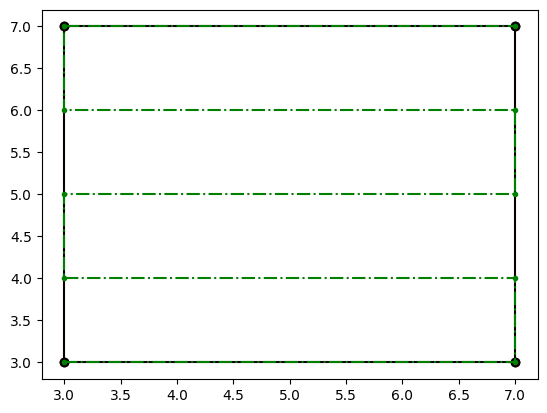

In [73]:


# returns true iff the signed distance of p and l is smaller than the signed distance of q and l.


def has_smaller_signed_distance_to_line(ln: Line_2, p: Point_2, q: Point_2):
    return (ln.oriented_side(p)*squared_distance(ln, p)) < (ln.oriented_side(q)*squared_distance(ln, q))


def find_south(pg: Polygon_2, ln: Line_2):
    vc = pg.vertices_circulator()
    v = vc
    done = vc.next()
    while True:
        p = vc.next()
        q = v.next()
        if has_smaller_signed_distance_to_line(ln, p, q):
            v = vc
        else:
            v = v

        if vc.next() == done:
            break

    return vc


def find_north(pg: Polygon_2, ln: Line_2):
    return find_south(pg, ln.opposite())

# Check whether polygon 'pg' is weakly monotone perpendicular to 'ln' (x_axis).


def is_weakly_monotone(pg: Polygon_2, ln: Line_2):

    # Find north and south circulator
    north = find_north(pg, ln)
    south = find_south(pg, ln)

    # Go from south to north
    c = south
    c_prev = south
    while (c != north):
        c.next()
        if has_smaller_signed_distance_to_line(ln, c, c_prev):
            return False
        c_prev = c

    # Go opposite direction
    c = south
    c_prev = south
    while (c != north):
        c.prev()
        if has_smaller_signed_distance_to_line(ln, c, c_prev):
            return False
        c_prev = c

    return True


# Get all unique edges directions which are monotone.


def get_all_sweepable_edge_directions(pg: Polygon_2):
    dirs = []
    for e in pg.edges():
        # Check if this edge direction is already in the set.
        last = next((dir for dir in dirs if orientation(
            dir.vector(), e.to_vector()) == COLLINEAR), None)
        if last != None:  # Existing edge direction
            continue
        # Check if the polygon is monotone perpendicular to this edge direction.
        if is_weakly_monotone(pg, e.supporting_line()):
            dirs.append(e.direction())

    return dirs

# Sort vertices of polygon based on signed distance to line l.


def sort_vertices_to_line(pg: Polygon_2, ln: Line_2):
    pts = list()
    for v in pg.vertices():
        pts.append(v)

    # SORT: returns true iff the signed distance of p and l is smaller than the signed distance of q and l.
    from functools import cmp_to_key
    sorted(pts, key=cmp_to_key(
        lambda p, q: has_smaller_signed_distance_to_line(ln, p, q)))
    return pts

# Find the intersections between a polygon and a line and sort them by the
# distance to the perpendicular direction of the line.


def find_intersections(pg: Polygon_2, ln: Line_2, reverse=False):
    pts = list()
    for e in pg.edges():
        obj = intersection(ln, e)
        if obj.is_Segment_2():
            ls = obj.get_Segment_2()
            if ls.source() not in pts:
                pts.append(ls.source())
            if ls.target() not in pts:
                pts.append(ls.target())

        elif obj.is_Point_2():
            pt = obj.get_Point_2()
            if pt not in pts:
                pts.append(pt)

    # SORT: returns true iff the signed distance of p and l is smaller than the signed distance of q and l.
    # from functools import cmp_to_key
    perp_ln = ln.perpendicular(ln.point(0))
    return sorted(pts, key=lambda p: squared_distance(perp_ln, p), reverse=reverse)
    # return sorted(pts, key=cmp_to_key(lambda p,q: has_smaller_signed_distance_to_line(perp_ln, p, q)), reverse=reverse)

# Same as findIntersections but only return first and last intersection.


def find_sweep_segment(pg: Polygon_2, ln: Line_2, min_intersections=0):
    pts = find_intersections(pg, ln)
    if len(pts) <= min_intersections:
        return False, None
    lsg = Segment_2(pts[0], pts[-1])  # Front and Back
    return True, lsg


def find_best_sweep_dir(pg: Polygon_2):
    min_altitude = float("inf")
    best_dir = None
    for dir in get_all_sweepable_edge_directions(pg):
        south = find_south(pg, Line_2(Point_2(ORIGIN), dir)).next()
        north = find_north(pg, Line_2(Point_2(ORIGIN), dir)).next()
        orthogoanl_vec = dir.vector().perpendicular(POSITIVE)
        line_through_n = Line_2(north, orthogoanl_vec.direction())
        s_proj = line_through_n.projection(south)
        altitude = np.sqrt(squared_distance(north, s_proj))
        # print(dir, south, north, altitude)
        if altitude < min_altitude:
            min_altitude = min_altitude
            if best_dir is not None:
                best_dir = dir

    return min_altitude, best_dir

# Compute the sweep by moving from the bottom to the top of the polygon.


def compute_sweep(pg: Polygon_2, graph: vg.VisGraph, offset: float, dir: Direction_2, ccw: bool):
    waypoints = list()  # Output
    sq_offset = offset * offset  # Used by observability

    # Input polygon must have ccw orientation
    if not pg.is_counterclockwise_oriented():
        return False, waypoints

    # Find start sweep
    sweep = Line_2(Point_2(0, 0), dir)
    pts = sort_vertices_to_line(pg, sweep)
    sweep = Line_2(pts[0], dir)

    # Calculate sweep offset using sensor model parameters
    offset_vector = sweep.perpendicular(pts[0]).to_vector()  # Vector_2
    offset_vector = offset * \
        (offset_vector/np.sqrt(offset_vector.squared_length()))

    result, sweep_segment = find_sweep_segment(pg, sweep)
    while result is True:
        # Align sweep segment
        if ccw:
            sweep_segment = sweep_segment.opposite()

        # Connect previous segment
        if len(waypoints) > 0:
            result, path = calculate_shortest_path(
                graph, waypoints[-1], sweep_segment.source())
            if result == False:
                print(
                    f"Failed to find path from {waypoints[-1]} to {sweep_segment.source()}")
                return False, waypoints

            for pt in path:
                waypoints.append(pt)

        waypoints.append(sweep_segment.source())
        if not sweep_segment.is_degenerate():
            waypoints.append(sweep_segment.target())

        # Translate the sweep segement by applying affine translation
        sweep = apply_affine_translation(sweep_segment, offset_vector)

        # Find next sweep segment
        prev_sweep_segment = sweep_segment.opposite() if ccw else sweep_segment
        result, sweep_segment = find_sweep_segment(pg, sweep.supporting_line())

        # Add a final sweep
        if (result == False) and (not(
            (len(waypoints) > 0 and waypoints[-1] == pts[-1]) or
            (len(waypoints) > 1 and waypoints[-2] == pts[-1])
        )):
            sweep = Line_2(pts[-1], dir)
            result, sweep_segment = find_sweep_segment(pg, sweep)
            if result == False:
                print(f"Failed to create final sweep at point: {pts[-1]}")
                return False, waypoints

            # Don't add very close sweep segments
            if squared_distance(sweep_segment, prev_sweep_segment) < 0.1:
                break

        # Check observability of vertices between sweeps
        if result:
            unobservable_point = check_observability(
                prev_sweep_segment, sweep_segment, pts, sq_offset)
            if unobservable_point != pts[-1]:
                sweep = Line_2(unobservable_point[0], dir)
                result, sweep_segment = find_sweep_segment(pg, sweep)
                if result == False:
                    print(
                        f"Failed to create extra sweep at point: {unobservable_point[0]}")
                    return False, waypoints

    return True, waypoints

# Compute the sweep by moving from the bottom to the top of the polygon.

def check_observability(prev_sweep: Segment_2, sweep: Segment_2, sorted_pts: list, max_sq_distance: float):
    lowest_unobservable_point = sorted_pts[-1]
    for pt in sorted_pts:
        if prev_sweep.supporting_line().has_on_positive_side(pt):
            continue

        if sweep.supporting_line().has_on_negative_side(pt):
            break

        sq_distance_prev = squared_distance(prev_sweep, pt)
        sq_distance_curr = squared_distance(sweep, pt)

        if (sq_distance_prev > max_sq_distance) and (sq_distance_curr > max_sq_distance):
            lowest_unobservable_point = pt
            break

    return lowest_unobservable_point

# Create visibility graph


def create_visbility_graph(pg: Polygon_2):
    polys = [[vg.Point(p.x(), p.y()) for p in pg.vertices()]]
    return build_visgraph(polys)


# Connect to points in the polygon using the visibility graph.
def calculate_shortest_path(graph: vg.VisGraph, start: Point_2, goal: Point_2, thresh=0.001):

    path = graph.shortest_path(vg.Point(start.x(), start.y()), vg.Point(goal.x(), goal.y()))

    if len(path) < 2:
        print(f"No valid path from {start} to  {goal}.")
        return False, list()

    shortest_path = [Point_2(path[0].x, path[0].y)]
    for pt in path[1:]:
        ppt = shortest_path[-1] # previous point
        npt = Point_2(pt.x, pt.y) # current point
        if squared_distance(ppt, npt) > thresh: # if distance is greather than threshold
            shortest_path.append(npt) # Append to the output list
            
    return True, shortest_path


def check_same_direction(ls1: Segment_2, ls2: Segment_2):
    """Check if the two line segments have same direction.

    Args:
        ls1 (Segment_2): First line segment
        ls2 (Segment_2): Second line segment

    Returns:
        Bool: True if both have same direction, False otherwise
    """
    v1 = ls1.to_vector()
    v2 = ls2.to_vector()
    v1.normalize()
    v2.normalize()
    dv = v1-v2
    return True if ((abs(dv.x()) < 0.001) and (abs(dv.y()) < 0.001)) else False


# A segment is observable if all vertices between two sweeps are observable.
def vertices_between_segments(pg: Polygon_2, ls1: Segment_2, ls2: Segment_2):
    """Find the polygon vertices between the ls1 and ls2.
    Calculate the average distances with respect to ls2.

    Args:
        pg (Polygon_2): _description_
        ls1 (Segment_2): _description_
        ls2 (Segment_2): _description_

    Returns:
        vertices list(Point_2): List of vertices between the two line segemnts.
        avgDist (float): Average distance of points wrt ls2.
    """
    l1 = ls1.supporting_line()
    l2 = ls2.supporting_line()
    vertex_dist = list()
    vertices = list()
    avgDist = 0
    for pt in pg.vertices():
        o_wrt_l1 = l1.oriented_side(pt)
        o_wrt_l2 = l2.oriented_side(pt)
        if (o_wrt_l1 == 1) and (o_wrt_l2 == -1) or ((o_wrt_l1 == -1) and (o_wrt_l2 == 1)):
            vertices.append(pt)
            vertex_dist.append(np.sqrt(squared_distance(ls2, pt)))
            avgDist = np.mean(vertex_dist)
            
    return vertices, avgDist


def find_polygon_unique_edge_orientation(pg: Polygon_2):
    """Find all non-collinear edges orientation. 
    If there are collinear edges, keep the one with largest length.

    Args:
        pg (Polygon_2): Input polygong with ordered (CW or CCW) vertices

    Returns:
        edges list(Segment_2): List of unique edge directions.
    """

    # Temporary list inorder to avoid re-calculating edge directions.
    dirs = list()
    edges = list()  # Correponging edges

    for e in pg.edges():
        found = False
        dir = e.to_vector()  # Direction vector from target to source
        for idx, d in enumerate(dirs):
            if (orientation(dir, d)) == COLLINEAR:
                found = True
                if e.squared_length() > edges[idx].squared_length():
                    # Replace edge and directon
                    edges[idx] = e
                    dirs[idx] = dir

        if not found:
            # Direction not already present, thus add it to the list
            dirs.append(dir)
            edges.append(e)

    return edges  # Edges are more useful than only dirs


def compute_waypoints(pg: Polygon_2, graph: vg.VisGraph, sweeps: list(), offset=0.001):
    waypoints = []
    if len(sweeps) > 1:
        waypoints.append(sweeps[0].source())
        waypoints.append(sweeps[0].target())
        reverse_sweep_path = True
        for sweep in sweeps[1:]:
            if reverse_sweep_path:
                sweep = sweep.opposite()
            reverse_sweep_path = not reverse_sweep_path  # Invert for next sweep-line
            start = sweep.source()
            goal = sweep.target()
            # connect previous segments
            _, origin, _, _ = project_point_on_polygon_hull(waypoints[-1], pg, offset)
            _, destination, _, _ = project_point_on_polygon_hull(start, pg, offset)

            result, path = calculate_shortest_path(graph, origin, destination)
            if result == True:
                for pt in path[1:-1]:
                    waypoints.append(pt)
            # Add current segment
            waypoints.append(start)
            waypoints.append(goal)

        path_length = 0
        ppt = waypoints[0]
        for pt in waypoints[1:]:
            path_length += np.sqrt(squared_distance(ppt, pt))
            ppt = pt

    return waypoints, path_length


def compute_sweep_lines(pg: Polygon_2, start: Segment_2, offset: float, ccw: bool):
    sweeps = list()  # Output
    sq_offset = offset * offset  # Used by observability

    # Input polygon must have ccw orientation
    if pg.is_clockwise_oriented():
        pg.reverse_orientation()

    # Find start sweep
    sweep = start.supporting_line()
    print(f"CCW-Direction: {ccw}")
    print(f"StartingLine: {start}")

    # Calculate sweep offset using sensor model parameters
    offset_dir = sweep.perpendicular(start.source()).direction()  # Vector_2
    offset_vector = Vector_2(offset_dir.dx(), offset_dir.dy())
    offset_vector.normalize()
    offset_vector = offset * offset_vector
    print(f"OffsetVector: {offset_vector}")

    result, sweep_segment = find_sweep_segment(pg, sweep)
    sweep_segment = sweep_segment.opposite() if ccw else sweep_segment
    
    while result is True:
        # Align sweep segment
        sweeps.append(sweep_segment)

        # Find next sweep segment
        # Translate the sweep segement by applying affine translation
        # Previous line segment
        prev_sweep_segment = sweep_segment
        sweep = apply_affine_translation(sweep_segment, offset_vector)
        result, sweep_segment = find_sweep_segment(pg, sweep.supporting_line())
        if result == True:
            # Reverse direction if find_sweep_segment calculated opposite direction
            if sweep_segment.is_degenerate():
                sweeps.append(sweep_segment)
                result = False
            elif check_same_direction(prev_sweep_segment, sweep_segment) == False:
                sweep_segment = sweep_segment.opposite()

        # Add a final sweep wrt to last sweep segment, if possible
        if  result == False:
            vertices, avg_dist = vertices_between_segments(pg, sweep, prev_sweep_segment)
            # Don't add very close sweep segments
            if (len(vertices) == 0) or (avg_dist < (offset/2.0)):
                break

            offset_vector.normalize()
            offset_vector = avg_dist * offset_vector
            # Translate the sweep segement by applying affine translation
            sweep = apply_affine_translation(prev_sweep_segment, offset_vector)
            result, sweep_segment = find_sweep_segment(pg, sweep.supporting_line())
            if result:
                if check_same_direction(prev_sweep_segment, sweep_segment) == False:
                    sweeps.append(sweep_segment.opposite())
                else:
                    sweeps.append(sweep_segment)
                break

    return True, sweeps

# Compute sweeps for all sweepable directions counter-clockwise and clockwise.
def compute_all_sweeps(pg: Polygon_2, sweep_offset: float):
    sweeps_cluster = list()

    # Find all sweepable directions
    dirs = find_polygon_unique_edge_orientation(pg)
    g = create_visbility_graph(pg)
    for dir in dirs:
        # Find Sweep without inverting dir vector
        result, sweeps = compute_sweep_lines(pg, dir, sweep_offset, False)
        if result:
            # sweeps_cluster.append(sweeps)
            waypoints, path_length = compute_waypoints(pg, g, sweeps, 0.001)
            print(f"path_length: {path_length:0.2f}")
            if len(waypoints) > 1:
                sweeps_cluster.append(waypoints)
                
        # Find Sweep by inverting dir vector
        result, sweeps = compute_sweep_lines(pg, dir, sweep_offset, True)
        if result:
            # sweeps_cluster.append(sweeps)
            waypoints, path_length = compute_waypoints(pg, g, sweeps, 0.001)
            print(f"path_length: {path_length:0.2f}")
            if len(waypoints) > 1:
                sweeps_cluster.append(waypoints)
                
    return sweeps_cluster


def optimal_sweep_dir(pg: Polygon_2):
    min_dir = None
    min_altitude = float('inf')
    for dir in find_polygon_unique_edge_orientation(pg):
        for e in pg.edges():
            alt = np.sqrt(squared_distance(dir, e))
            if (alt > 0) and (alt < min_altitude):
                min_altitude = alt
                min_dir = dir
            
    return min_dir, min_altitude


# for pt in sort_vertices_to_line(pg1, l1):
    # print(f"{pt.x():+0.2f}, {pt.y():+0.2f}")

# for pt in find_intersections(pg1, l1):
#     print(f"{pt.x():+0.2f}, {pt.y():+0.2f}")

# result, ls2 = find_sweep_segment(pg1, l1)
# print(f"find_sweep_segment: {result}, {ls2.source()}, {ls2.target()}")

# v = find_south(pg1, l1)
# v = find_north(pg1, l1)
# print(v.next())

# print(is_weakly_monotone(pg2, l2))
# print(is_weakly_monotone(pg2, l3))

# print(is_weakly_monotone(pg1, l2))
# print(is_weakly_monotone(pg1, l3))

# find_best_sweep_dir(pg1)

# print(f"North wrt e[x]:")
# print(find_north(pg5, edges[5].supporting_line()).next())

# compute_sweep(pg5, None, 1, dirs[0], True)

# offset_vector = ls2.supporting_line().perpendicular(ls2.source()).to_vector() # Vector_2
# offset_vector = -5 * (offset_vector/np.sqrt(offset_vector.squared_length()))
# print(f"LS: {ls2}")
# print(f"OV: {offset_vector}")
# print(ls2.supporting_line().projection(Point_2(offset_vector.x(), offset_vector.y())))
# print(apply_affine_translation(ls2, offset_vector))

# print("Unique directions")
# dir_edges = find_unique_polygon_directions(pg5)
# for d in dir_edges:
#     dir = d.direction()
#     print (apply_affine_translation(d, Vector_2(dir.dx(), dir.dy())))

# orientation(lst[0], lst[1])
# result, path = calculate_shortest_path(g, start, goal)
# plot_vis_graph_path(plt.gca(), path, '--go')

# print(apply_affine_translation(Segment_2(Point_2(0,0), Point_2(10,0)), Vector_2(0, 5)))

pgx = pg2
print(f"isSimple: {pgx.is_simple()}")
print(f"isConvex: {pgx.is_convex()}")
dirs = find_polygon_unique_edge_orientation(pgx)
print(f"find_polygon_unique_edge_orientation:")
for dir in dirs:
    print(dir)

g = create_visbility_graph(pgx)
plot_vis_graph(g, plt.gca())
print(f"compute_sweep_lines:")
result, sweeps = compute_sweep_lines(pgx, dirs[0], 1, False)
if result:
    # print(f"Sweeps:")
    # for sweep in sweeps:
    #     print(sweep)
        # plot_cgal_segment2(sweep, plt.gca(), "--r.")
    waypoints, path_length = compute_waypoints(pgx, g, sweeps, 0.001)
    print(f"path_length: {path_length:0.2f}")
    if len(waypoints) > 1:
    #     print(f"Waypoints:")
    #     for wp in waypoints:
    #         print(wp)
        plot_cgal_waypoints(waypoints, plt.gca(), "-.g.")


IsSimple [No intersection and holes]:  True
IsConvex [All internal angle < 180]:  True
IsClockwiseOriented:  False
IsCounterClockwiseOriented:  True
IsCollinearOriented:  False
Area:  3.0
Orientation:  1
Vertices:  5
BBox:  0 0 2 2
BottomVertex:  0
RightVertex:  2
TopVertex:  3
LeftVertex:  0


<bound method Polygon_2.is_collinear_oriented of <CGAL.CGAL_Kernel.Polygon_2; proxy of <Swig Object of type 'Polygon_2 *' at 0x7f140049b510> >>

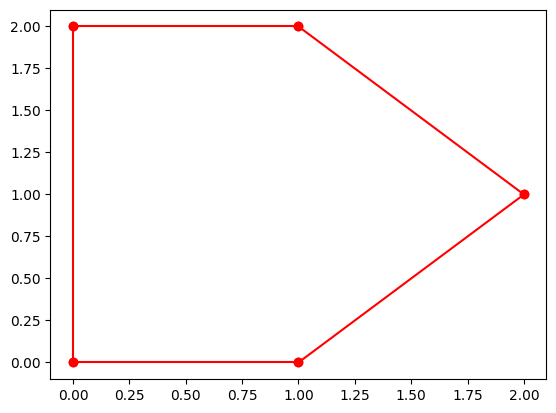

In [14]:
# Display properties
plot_cgal_polygon2(pg1, plt.gca())
cgal_polygon_properties(pg1)
# cgal_line_properties(l1)
# cgal_linesegment_properties(ls1)
pg1.is_collinear_oriented

In [16]:
# print(project_on_polygon_hull(vg.Point(1, 1), g, 0, 0.01))
# print(pg1.bounded_side(Point_2(1, 1))) # Returns: ON_BOUNDED_SIDE(1), ON_BOUNDARY(0) or ON_UNBOUNDED_SIDE(-1)

# Project point on polygon
pt = Point_2(2, 0)
cedge, npt, dist, bside = project_point_on_polygon_hull(pt, pg1, 0.001) # closest_edge, proj_pt, edge_distance, pg.bounded_side(proj_pt),
print("project_point_on_polygon_hull")
print(cedge)
# print(cedge.direction())
print(npt)
print(f"{dist:0.3f}")
print(bside)

project_point_on_polygon_hull
1 0 2 1
1.49929 0.500707
0.708
1


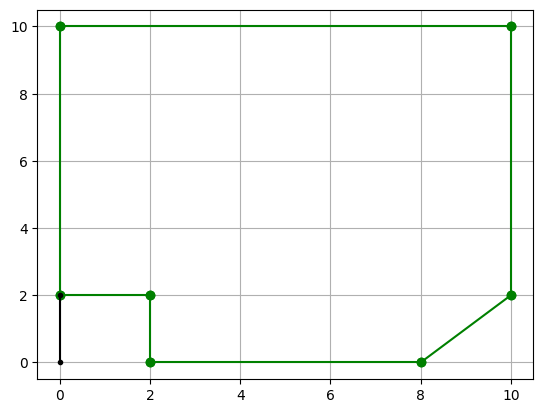

In [17]:
l4 = l3#Line_2(Point_2(0,1), Point_2(1,1))
# plot_cgal_polygon2(pg2, ax=plt.gca(), params="-ro")
plot_cgal_polygon2(pg4, ax=plt.gca(), params="-go")
# plot_cgal_segment2(ls1, ax=plt.gca(), params="-b.")
plot_cgal_line2(l4, ax=plt.gca(), params="-k.")
# plot_cgal_line2(Line_2(Point_2(ORIGIN), Direction_2(2,10)), ax=plt.gca(), params="-k.") # Horizontal line
plt.grid('both')
plt.show()

In [18]:
yvalue = 60
xvalue = 0
offset = 0.5
# Horizontal lines
ls1 = Segment_2(Point_2(0, yvalue-offset), Point_2(100, yvalue-offset))
ls2 = Segment_2(Point_2(0, yvalue+offset), Point_2(100, yvalue+offset))
ls1 = ls1.opposite()
ls2 = ls2.opposite()

# Vertical lines
ls1 = Segment_2(Point_2(xvalue-offset, 0), Point_2(xvalue-offset, 100))
ls2 = Segment_2(Point_2(xvalue+offset, 0), Point_2(xvalue+offset, 100))
ls1 = ls1.opposite()
ls2 = ls2.opposite()


vertices_between_segments(pg1, ls1, ls2)

([<CGAL.CGAL_Kernel.Point_2; proxy of <Swig Object of type 'Point_2 *' at 0x7f140018f690> >,
  <CGAL.CGAL_Kernel.Point_2; proxy of <Swig Object of type 'Point_2 *' at 0x7f140018fa50> >],
 0.5)

CCW-Direction: False
StartingLine: 0 0 1 0
OffsetVector: 0 0.5
path_length: 9.41
CCW-Direction: True
StartingLine: 0 0 1 0
OffsetVector: 0 0.5
path_length: 9.41
CCW-Direction: False
StartingLine: 1 0 2 1
OffsetVector: -0.353553 0.353553
path_length: 8.86
CCW-Direction: True
StartingLine: 1 0 2 1
OffsetVector: -0.353553 0.353553
path_length: 9.26
CCW-Direction: False
StartingLine: 2 1 1 2
OffsetVector: -0.353553 -0.353553
path_length: 8.86
CCW-Direction: True
StartingLine: 2 1 1 2
OffsetVector: -0.353553 -0.353553
path_length: 9.26
CCW-Direction: False
StartingLine: 0 2 0 0
OffsetVector: 0.5 0
path_length: 9.41
CCW-Direction: True
StartingLine: 0 2 0 0
OffsetVector: 0.5 0
path_length: 9.41


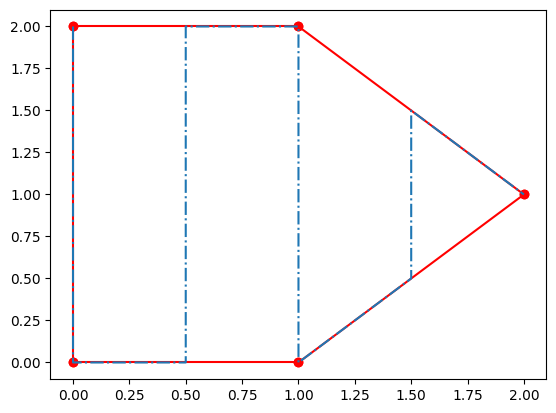

In [52]:
sweeps = compute_all_sweeps(pg1, 0.5)
plot_cgal_polygon2(pg1, plt.gca())
for sweep in sweeps[-1:]:
    plot_cgal_waypoints(sweep, plt.gca(), "-.")


OptimalDirection: 3 3 7 3, Altitude: 4.0


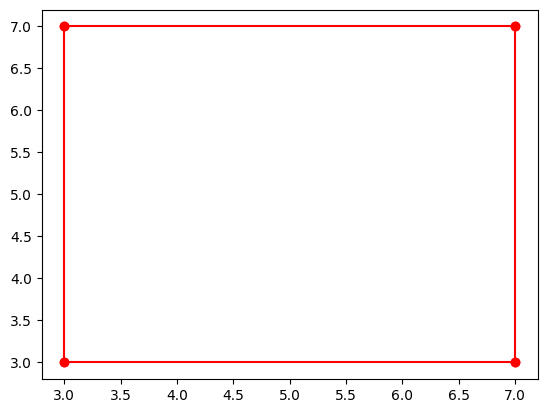

In [74]:
pgx = pg2
dir, alt = optimal_sweep_dir(pgx)
print(f"OptimalDirection: {dir}, Altitude: {alt}")
plot_cgal_polygon2(pgx, plt.gca())